# Reliability of seasonal forecasts

Production date: 07-06-2024

Produced by: Johannes Langvatn (METNorway)

## 🌍 Use case: Initial assessment of the reliability of forecast probabilities by a climate services provider

## ❓ Quality assessment question
* **How reliable are the probabilities of the seasonal forecasts for different regions and parameters of interest**

Seasonal forecasts are inherently probabilistic and should be interpreted and evaluated as such. Reliability, a key attribute of a forecast system, measures how closely the conditional mean of the observations aligns with the corresponding forecast. This notebook provides estimates of forecast reliability. It should be noted that reliability is only one of several attributes measuring the goodness of a forecast system [Murphy, 1993 \[1\]](https://doi.org/10.1175/1520-0434(1993)008<0281:WIAGFA>2.0.CO;2.). 

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The reliability of the 1-month, 2-meter air temperature forecasts for June, July, and August in the climatological upper tercile varies across different regions.
* Reliability diagrams are useful tools for assessing the quality of probabilistic forecasts.
* Reliability is just one of several metrics used to evaluate a forecast, and should be considered alongside other attributes such as sharpness, discrimination, and resolution.
```

## 📋 Methodology

This notebook follows the approach suggested by [Weisheimer and Palmer (2014) \[2\]](https://doi.org/10.1098/rsif.2013.1162). which was later applied and slightly modified by [Manzanas et al. (2022) \[3\]](https://doi.org/10.1029/2021GL094662). Reliability diagrams are constructed for forecasts of 2-meter air temperature reaching the climatological upper tercile, based on SEAS5 (ECMWF) single-level seasonal forecasts. These are then compared with ERA5 single-level data, which is considered the reference or 'truth.
There are several methods for constructing reliability diagrams. Since the primary focus is on verifying probabilities for a specific region, it is important to assess the actual forecast. This approach results in a relatively small data sample (e.g., 24 years of hindcasts x 3 months per season), meaning the results may not be very robust. To address this, [Weisheimer and Palmer (2014) \[2\]](https://doi.org/10.1098/rsif.2013.1162) suggested calculating a linear regression of the reliability line, weighted by the sample size in each bin. The uncertainty of the slope of the reliability line was further estimated using bootstrapping. Based on the characteristics of the reliability line and its associated uncertainty, the forecasts were categorized into five reliability categories: "perfect," "still very useful for decision-making," "marginally useful," "not useful," and "dangerously useless" (see below for more details and/or [Weisheimer and Palmer (2014) \[2\]](https://doi.org/10.1098/rsif.2013.1162)

This notebook calculates, presents, and discusses the reliability diagrams for a specific region: northern Europe. For this region, an alternative method of constructing the reliability diagram, similar to the approach shown on the [ECMWF web pages](https://charts.ecmwf.int/products/seasonal_system5_verification_reliability_2mtm?area=EURO&base_time=201712010000&stats=BRVT67&valid_time=201801010000), is also presented and compared. Finally, the reliability categories for a range of regions worldwide are calculated and summarized in a table.


**[1. Choose data to use and setup code:](section-1)**
   - Choose a selection of forecast systems and versions, hindcast period (normally 1993-2016), regions and parametre to compute reliability for.
   - Choose an example region for computing the reliability without computing the area average

**[2. ERA5 data retrieval and area averages:](section-2)**
   - Retrieve reanalysis-data for the selected parameters above, from the data catalogue ”ERA5 monthly averaged data on single levels from 1940 to present”
   - Compute the 2 m temperature anomaly by computing the climatology subtracting climatology from the reanalysis.
   - Compute the spatial mean of 2 m temperature anomaly for each selected region.

**[3. Seasonal hindcast data retrieval and area average:](section-3)**
   - Retrieve hindcast data for all ensemble members for the selected parameters above, from the data catalogue ”Seasonal forecast monthly statistics on single levels”
   - Compute the 2 m temperature anomaly by computing the climatology subtracting climatology from the hindcast.
   - Compute the spatial mean of 2 m temperature anomaly for each selected region.

**[4. Plot and describe results:](section-4)**
   - The forecasted frequency of 2 m temperature anomaly being warmer than climatology is calculated
   - The observation if the month was warmer in the reanalysis than the reanalysed climatology is noted
   - The reliability is then computed by bootstrapping from the pool of forecasted frequency and their respective observations
   - This is then plotted as confidence intervals of (12.5%, 87.5%) in the reliability plots
   - The reliability is also computed for the example region


## 📈 Analysis and results

(section-1)=
### 1.Choose the data to use and setup code
First we import the needed code packages, and set the seaborn plot-style for matplotlib to use for plotting


In [1]:
import regionmask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from c3s_eqc_automatic_quality_control import diagnostics, download, utils
from sklearn.linear_model import LinearRegression

plt.style.use("seaborn-v0_8-notebook")

In this section, the customisable options of the notebook are set. These variables consists of:

- Model forecast system 
    - forecast centre 
    - system version
- Time
    - first year of the model hindcast
    - last year of the model hindcast
    - forecast month
    - number of months leadtime for hindcast 
- Regions of interest
    - number of SREX region (see [SREX in the regionmask-module](https://regionmask.readthedocs.io/en/stable/defined_scientific.html#srex-regions) for choices)
- Weather parametre
    - name of variable in grib-file
    - name of variable in CADS-api
- Download parameters
    - chunk size of the data
    - number of concurrent request for parallel download 
- Combination of originating centre and model system (Operational forecast model systems per March 2024):
    - centre = "ecmwf", system = "51"
    - centre = "ukmo", system = "602"
    - centre = "meteo_france", system = "8"
    - centre = "dwd", system = "21"
    - centre = "cmcc", system = "35"
    - centre = "ncep", system = "2"
    - centre = "jma", system = "3"
    - centre = "eccc", system = "2"
    - centre = "eccc", system = "3"

In [2]:
models = {
    "ecmwf": "51",
}

year_start_hindcast = 1993
year_stop_hindcast = 2016
months = [5,6,7]
leadtime_month = 2
# reanalysis_month is month + leadtime_month - 1 (since leadtime_month 1 for May is May)
reanalysis_month = [6,7,8]
var_grb = 't2m'
var_api = '2m_temperature'
chunks = {"year": 1}
n_jobs = 1 
region_masks = list(range(1,26+1))
example_region = 11
collection_id = "seasonal-monthly-single-levels"
collection_id_reanalysis = "reanalysis-era5-single-levels-monthly-means"

# Construct the common request to be sent to CADS
common_request = {
    "format": "grib",
    "area": [89.5, -179.5, -89.5, 179.5],
    "variable": var_api,
    "grid": "1/1",
}

all_datasets = {}

Define functions needed later to find correct bins for the observations, computing the reliability, and plotting the results

In [3]:
def score(coeff_lower, coeff_middle, coeff_higher):
    # Scores defined in the Weisheimer paper
    if coeff_lower >= 2/3 and coeff_lower <= 1:
        if coeff_higher >= 1 and coeff_higher <= 3:
            return "perfect", 5
        return "still very useful for decision-making", 4
    elif coeff_middle >= 0.5:
        return "still very useful for decision-making", 4
    elif coeff_lower > 0:
        return "marginally useful", 3
    elif coeff_higher >= 0 and coeff_lower <= 0: 
        return "not useful", 2
    elif coeff_higher < 0:
        return "dangerously useless", 1
    return "Error", -1


def find_correct_bin(array, value):
    index = np.abs(value - array[:, None]).argmin(axis=0)
    # Non-Vectorized version
    # index = np.abs(array-value).argmin()
    return index


def bootstrap_coefficients(total_observations, observations_x, N=1000):
    # could be cleaner, faster, but 1000 is fast.
    coefficients = []
    for _ in range(N):
        observations_i = np.zeros_like(observations_x)
        non_observations_i = np.zeros_like(observations_x)
        for utplukk in range(len(total_observations)):
            random_index = np.random.randint(0,len(total_observations))
            forecasted_frequency, observed = total_observations[random_index]
            idx = find_correct_bin(observations_x, forecasted_frequency)
    
            observations_i[idx] += observed
            non_observations_i[idx] += 1 - observed 
        indices = observations_i.nonzero()
        hit_rate_i = observations_i[indices]/(observations_i[indices]+non_observations_i[indices])
        regr = LinearRegression()
        # Tips to change weights to achieve what you want (No weights to focus on climatology (mostly))
        regr.fit(observations_x[indices].reshape(-1,1), hit_rate_i.reshape(-1,1), (observations_i+non_observations_i)[indices])
        coefficients.append(regr.coef_[0])
    return coefficients


def plot_reliability(quantiles, observations, non_observations, observed_values, model, region_mask,
                     var_grb=var_grb, leadtime_month = leadtime_month, plot=True):
    x_range = np.linspace(0, 1, 1000)
    average_forecast = np.zeros_like(observations_x)
    for index, list_of_values in enumerate(observed_values):
        if len(list_of_values) > 0:
            average_forecast[index] = np.average(list_of_values)
    indices = observations.nonzero()
    x = observations_x[indices]
    hit_rate = observations[indices]/(observations[indices]+non_observations[indices])
    regr = LinearRegression()

    regr.fit(average_forecast[indices].reshape(-1,1), hit_rate.reshape(-1,1), (observations+non_observations)[indices])
    coeff_true = regr.coef_[0]
    if plot == True:
        sizing = np.array([len(item)for item in observed_values])
        norm_sizing = (sizing / np.linalg.norm(sizing))*750
        fig, ax = plt.subplots()
        ax.set_title(f"Reliability plot for season JJA leadtime {leadtime_month}, {var_grb}, from {model} in Area {region_mask}")
        ax.axvline(x=0.33, color="b")
        ax.axhline(y=0.33, color="b")
        ax.plot(x_range, x_range, "b--")
        ax.plot(average_forecast[indices], hit_rate, "r--")
        scatter = ax.scatter(average_forecast[indices], hit_rate, s=norm_sizing[indices], c ="r")
        handles, _ = scatter.legend_elements(prop="sizes", alpha=0.6, color="r")
        labels=[]
        for size in sorted(sizing[indices]):
            labels.append('$\\mathdefault{%d}$'%size)
        
        ax.plot(x_range, (1/3)/2 + x_range*(1/2), "b")
        ax.plot(x_range, coeff_true*x_range+0.33 - 0.33*coeff_true,"r")
        ax.legend(handles, labels)
        ax.set_xlim(0,1)
        ax.set_ylim(-0.01,1.01)
        ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_xlabel("Forecast probability")
        ax.set_ylabel("Observed probability")
        ax.fill_between(x_range, x_range*0.5 + 0.33/2 , where=x_range<=0.33, alpha = 0.2, color="b" )
        ax.fill_between(x_range, 0.5*(x_range) + 1, x_range*.5 + .33/2, where=x_range >=0.33, alpha = 0.2, color="b")
        if quantiles is not None:
            ax.fill_between(x_range, x_range*quantiles[0] + 0.33 - quantiles[0]*0.33, x_range*quantiles[1] + 0.33 - quantiles[1]*0.33, alpha=.3, color="r")
    return coeff_true

(section-2)=
### 2. ERA5 data retrieval and area averages

In this section the ERA5 reanalysis data are downloaded, the anomaly is computed and this is transformed into regional anomaly means for the regions defined in section 1. For the chosen 'example_region' a dataset is prepared with anomaly values for each grid cell.

In [4]:
request_reanalysis = common_request | {
    "product_type": "monthly_averaged_reanalysis",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "time": "00:00",
}
example_data = {"ERA5": {example_region: {}}}
model_type = "reanalysis"
years =range(year_start_hindcast, year_stop_hindcast + 1)

ds = download.download_and_transform(
    collection_id_reanalysis,
    request_reanalysis | {"year": list(map(str, years))},
    chunks=chunks,
    n_jobs=n_jobs,
    cached_open_mfdataset_kwargs={
        "combine": "nested",
        "concat_dim": "forecast_reference_time",
    },
)
# Store the downloaded dataset in the dictionary
all_datasets["reanalysis"] = ds
all_datasets_dict = {"ERA5": {}}

year_span = year_stop_hindcast - year_start_hindcast
for region_mask in region_masks:
    all_datasets_dict["ERA5"][region_mask] = {}
    for month in reanalysis_month:
        reanalysis = all_datasets["reanalysis"].isel(forecast_reference_time=range(month - 1, year_span*12 + month, 12 ))
        mask = regionmask.defined_regions.ar6.all.mask(reanalysis)
        re_ds = reanalysis.where((mask==region_mask).compute(), drop=True)[var_grb]
        if region_mask == example_region:
            climatology = diagnostics.time_weighted_mean(re_ds, time_name="forecast_reference_time")
            example_ds = re_ds - climatology
            quantiles = np.quantile(example_ds.values, [1 / 3, 2 / 3], axis=0)
            example_data["ERA5"][region_mask][month] = {"lower": quantiles[0], "upper" : quantiles[1], "dataset": example_ds }
        re_ds = diagnostics.spatial_weighted_mean(re_ds, weights=True)
        climatology = diagnostics.time_weighted_mean(re_ds, time_name="forecast_reference_time")
        climatology = climatology.mean(set(climatology.dims))
        re_ds -= climatology
        quantiles = np.quantile(re_ds.values, [1 / 3, 2 / 3], axis=0)
        all_datasets_dict["ERA5"][region_mask][month] = {"lower": quantiles[0], "upper" : quantiles[1], "dataset": re_ds }

100%|██████████| 24/24 [00:00<00:00, 61.97it/s]


(section-3)=
### 3. Seasonal hindcast data retrieval and area average

In this section the seasonal data are downloaded, the anomaly is computed and this is transformed into regional anomaly means for the regions defined in section 1. For the chosen 'example_region' a dataset is prepared with anomaly values for each grid cell.

In [5]:
request_seasonal = common_request | {
    "product_type": "monthly_mean",
    "month": [f"{month:02d}" for month in months],
    "leadtime_month": leadtime_month,
}

for centre, system in models.items():
    model_type = "hindcast"
    all_datasets[model_type] = {centre+system: None}
    request_seasonal["system"] = system
    request_seasonal["originating_centre"] = centre
    years =range(year_start_hindcast, year_stop_hindcast + 1)
    ds = download.download_and_transform(
        collection_id,
        request_seasonal | {"year": list(map(str, years))},
        chunks=chunks,
        n_jobs=n_jobs,
        backend_kwargs={
            "time_dims": (
                "forecastMonth",
                "indexing_time" if centre in ["ukmo", "jma", "ncep"] else "time",
            )
        },
        cached_open_mfdataset_kwargs={
            "concat_dim": "forecast_reference_time",
        },
    )
    # Store the downloaded dataset in the dictionary
    all_datasets[model_type][centre+system] = ds

for system,centre in models.items():
    model = system+centre
    all_datasets_dict[model] = {}
    example_data[model] = {example_region: {}}
    for region_mask in region_masks:
        all_datasets_dict[model][region_mask] = {}
        for forecast_month, month in enumerate(reanalysis_month):
            mask = regionmask.defined_regions.ar6.all.mask(all_datasets["hindcast"][model])
            forecast_ds = all_datasets["hindcast"][model].isel(forecast_reference_time=range(forecast_month, (1+year_span)*len(reanalysis_month), len(reanalysis_month)))
            forecast_ds = forecast_ds.where((mask==region_mask).compute(), drop=True)[var_grb]
            if region_mask == example_region:
                climatology = diagnostics.time_weighted_mean(forecast_ds, time_name="forecast_reference_time")
                example_ds = forecast_ds - climatology
                quantiles = np.quantile(example_ds.values, [1 / 3, 2 / 3], axis=1)
                example_data[model][region_mask][month] = {"lower": quantiles[0], "upper" : quantiles[1], "dataset": example_ds }
            forecast_ds = diagnostics.spatial_weighted_mean(forecast_ds, weights=True)
            climatology = diagnostics.time_weighted_mean(forecast_ds, time_name="forecast_reference_time")
            climatology = climatology.mean(set(climatology.dims))
            forecast_ds -= climatology
            quantiles = np.quantile(forecast_ds.values, [1 / 3, 2 / 3], axis=1)
            all_datasets_dict[model][region_mask][month] = {"lower": quantiles[0], "upper" : quantiles[1], "dataset": forecast_ds }
            

100%|██████████| 24/24 [00:00<00:00, 42.49it/s]
Error while converting 1 to months for forecastMonth.
 Units will not be converted.

Traceback:
Unable to convert from 'Unit('1')' to 'Unit('months')'.
Error while converting 1 to months for forecastMonth.
 Units will not be converted.

Traceback:
Unable to convert from 'Unit('1')' to 'Unit('months')'.
Error while converting 1 to months for forecastMonth.
 Units will not be converted.

Traceback:
Unable to convert from 'Unit('1')' to 'Unit('months')'.
Error while converting 1 to months for forecastMonth.
 Units will not be converted.

Traceback:
Unable to convert from 'Unit('1')' to 'Unit('months')'.
Error while converting 1 to months for forecastMonth.
 Units will not be converted.

Traceback:
Unable to convert from 'Unit('1')' to 'Unit('months')'.
Error while converting 1 to months for forecastMonth.
 Units will not be converted.

Traceback:
Unable to convert from 'Unit('1')' to 'Unit('months')'.
Error while converting 1 to months for f

(section-4)=
### 4. Plot and describe results


In this section the reliability of the spatially averaged anomalies are computed for all regions, and plotted for the 'example_region'. Then the reliability for each grid cell is computed and plotted for the 'example_region'. The reliability scores is then summarized in a table and the results are discussed

In [6]:
tercile = "upper"
operator = np.less_equal if "lower" else np.greater_equal
operator = np.greater_equal
results = {}


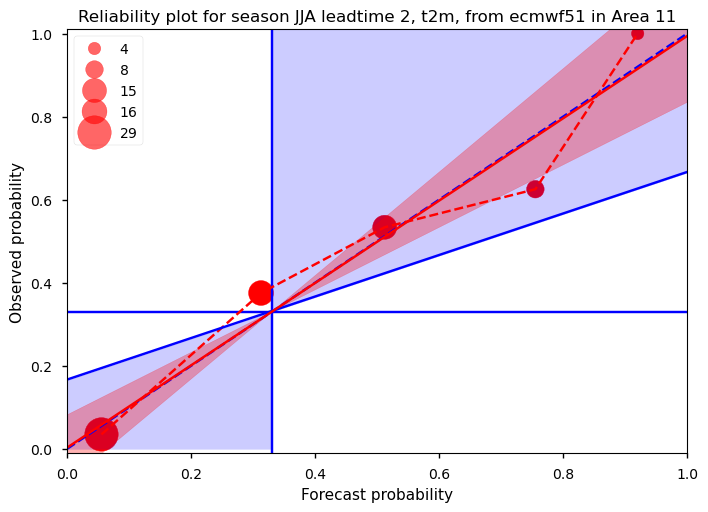

In [7]:
observations_x = np.linspace(0.1,0.9,5)

for system,centre in models.items():
    model = system+centre
    results[model] = {}
    model_dict = all_datasets_dict[model]
    for region_mask in region_masks:
        total_observations = [[],[]]
        observed_values = [[] for element in observations_x]
        observations = np.zeros_like(observations_x)
        non_observations = np.zeros_like(observations_x)

        for year in range(year_span+1):
            for month in reanalysis_month:
                # upper should be replaced by a flag for upper/lower
                limit_forecast = model_dict[region_mask][month][tercile]
                limit_reanalysis = all_datasets_dict["ERA5"][region_mask][month][tercile]
                # The NaNs are an artifact of the masking
                nonnan = ~np.isnan(limit_forecast.sum(axis=0)).flatten()

                values = model_dict[region_mask][month]["dataset"].isel(forecast_reference_time=year).values
                re_values = all_datasets_dict["ERA5"][region_mask][month]["dataset"].isel(forecast_reference_time = year).values
                # If upper/lower is chosen dynamically, this must also be updated to be compared dynamically, maybe 
                forecasted_frequency = ((operator(values, limit_forecast)).sum(axis=0) / len(values)).flatten()[nonnan]
                observed = ((operator(re_values, limit_reanalysis))).flatten()[nonnan]
        
                idx = find_correct_bin(observations_x, forecasted_frequency)
                for index, forecasted_value in zip(idx, forecasted_frequency):
                    observed_values[index].append(forecasted_value)
                observations[idx] += observed
                non_observations[idx] += 1 - observed 
                total_observations[0].append(forecasted_frequency)
                total_observations[1].append(observed.flatten())
                
        new_observations = np.array([np.array(total_observations[0]).flatten(), np.array(total_observations[1]).flatten()]).T
        
        coefficients = bootstrap_coefficients(new_observations, observations_x, N=1000)
        quantiles = np.quantile(np.asarray(coefficients), [0.125, 0.875])
        if region_mask != example_region:
            coeff_true = plot_reliability(quantiles, observations, non_observations, observed_values, model, region_mask, plot = False)
        else:
            coeff_true = plot_reliability(quantiles, observations, non_observations, observed_values, model, region_mask)
            plt.show()
        results[model][region_mask] = score(quantiles[0], coeff_true, quantiles[1])


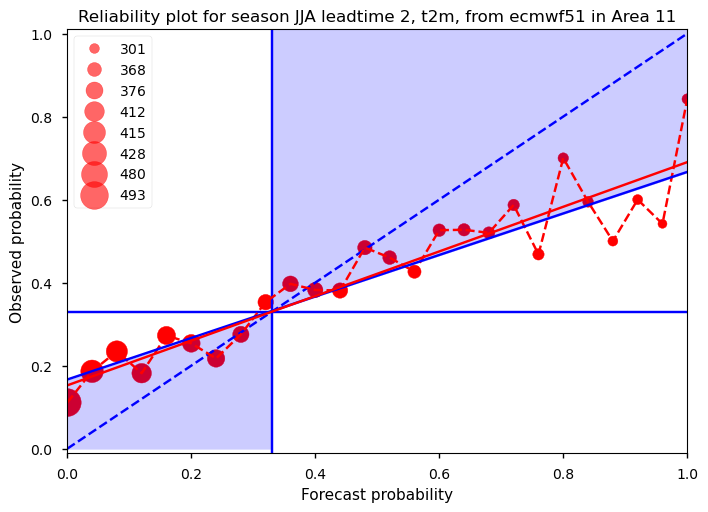

In [8]:
observations_x = np.linspace(0,1,26)

for system,centre in models.items():
    model = system+centre
    model_dict = example_data[model]
    region_mask = example_region
    total_observations = [[],[]]
    observed_values = [[] for element in observations_x]
    observations = np.zeros_like(observations_x)
    non_observations = np.zeros_like(observations_x)

    for year in range(year_span+1):
        for month in reanalysis_month:
            # upper should be replaced by a flag for upper/lower
            limit_forecast = model_dict[region_mask][month][tercile]
            limit_reanalysis = example_data["ERA5"][region_mask][month][tercile]
            # The NaNs are an artifact of the masking
            nonnan = ~np.isnan(limit_forecast.sum(axis=0)).flatten()

            values = model_dict[region_mask][month]["dataset"].isel(forecast_reference_time=year).values
            re_values = example_data["ERA5"][region_mask][month]["dataset"].isel(forecast_reference_time = year).values
            # If upper/lower is chosen dynamically, this must also be updated to be compared dynamically, maybe 
            forecasted_frequency = ((operator(values, limit_forecast)).sum(axis=0) / len(values)).flatten()[nonnan]
            observed = ((operator(re_values, limit_reanalysis))).flatten()[nonnan]
            idx = find_correct_bin(observations_x, forecasted_frequency)
            for index, forecasted_value in zip(idx, forecasted_frequency):
                observed_values[index].append(forecasted_value)
            observations[idx] += observed
            non_observations[idx] += 1 - observed 
            total_observations[0].append(forecasted_frequency)
            total_observations[1].append(observed.flatten())
            
    new_observations = np.array([np.array(total_observations[0]).flatten(), np.array(total_observations[1]).flatten()]).T
    
    coeff_true = plot_reliability(None, observations, non_observations, observed_values, model, region_mask)
    plt.show()
    quantiles = np.quantile(np.asarray(coeff_true), [0.125, 0.875])


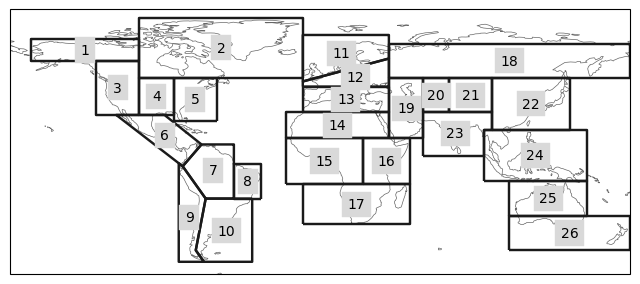

In [9]:
regionmask.defined_regions.srex[region_masks].plot();

In [10]:
print("| JJA - 2 metre air temperature | Score |")
print("|----|----|")
for region, value in results["ecmwf51"].items():
    print("| "+regionmask.defined_regions.srex[region].name +f" ({region}) | " + f"{value[0]} ({value[1]}) |")

| JJA - 2 metre air temperature | Score |
|----|----|
| Alaska/N.W. Canada (1) | still very useful for decision-making (4) |
| Canada/Greenl./Icel. (2) | perfect (5) |
| W. North America (3) | still very useful for decision-making (4) |
| C. North America (4) | still very useful for decision-making (4) |
| E. North America (5) | perfect (5) |
| Central America/Mexico (6) | still very useful for decision-making (4) |
| Amazon (7) | still very useful for decision-making (4) |
| N.E. Brazil (8) | perfect (5) |
| Coast South America (9) | perfect (5) |
| S.E. South America (10) | perfect (5) |
| N. Europe (11) | perfect (5) |
| C. Europe (12) | still very useful for decision-making (4) |
| S. Europe/Mediterranean (13) | perfect (5) |
| Sahara (14) | not useful (2) |
| W. Africa (15) | still very useful for decision-making (4) |
| E. Africa (16) | marginally useful (3) |
| S. Africa (17) | still very useful for decision-making (4) |
| N. Asia (18) | still very useful for decision-making (4)

| JJA - 2 metre air temperature | Score |
|----|----|
| Alaska/N.W. Canada (1) | still very useful for decision-making (4) |
| Canada/Greenl./Icel. (2) | perfect (5) |
| W. North America (3) | still very useful for decision-making (4) |
| C. North America (4) | still very useful for decision-making (4) |
| E. North America (5) | perfect (5) |
| Central America/Mexico (6) | still very useful for decision-making (4) |
| Amazon (7) | still very useful for decision-making (4) |
| N.E. Brazil (8) | perfect (5) |
| Coast South America (9) | perfect (5) |
| S.E. South America (10) | perfect (5) |
| N. Europe (11) | perfect (5) |
| C. Europe (12) | still very useful for decision-making (4) |
| S. Europe/Mediterranean (13) | perfect (5) |
| Sahara (14) | not useful (2) |
| W. Africa (15) | still very useful for decision-making (4) |
| E. Africa (16) | marginally useful (3) |
| S. Africa (17) | still very useful for decision-making (4) |
| N. Asia (18) | still very useful for decision-making (4) |
| W. Asia (19) | still very useful for decision-making (4) |
| C. Asia (20) | still very useful for decision-making (4) |
| Tibetan Plateau (21) | still very useful for decision-making (4) |
| E. Asia (22) | perfect (5) |
| S. Asia (23) | perfect (5) |
| S.E. Asia (24) | perfect (5) |
| N. Australia (25) | not useful (2) |
| S. Australia/New Zealand (26) | still very useful for decision-making (4) |

#### How to read the results
The reliability diagram shows the frequency with which an event occurs for a given forecasted probability. In the case of a perfectly reliable forecast, the forecasted probability and the observed frequency of occurrence should be equal, and the plotted reliability line (red dashed line connecting the red circles) should align with the diagonal line (dashed blue). The horizontal and vertical solid blue lines represent the climatology of the dataset (1/3 for terciles). When the red reliability line falls within the blue shaded area, the forecast demonstrates skill compared to the climatology (indicated by a positive Brier Skill Score). Additional information about the sharpness of the forecast can be inferred from the sizes of the red circles. Larger circles indicate that a certain probability is frequently forecasted. If the forecasts are consistently different from the climatological value, they are considered sharp. A forecast that is both different from the climatological value and reliable has the potential to be very useful.
The results for our specific case (Figure 1) show a strong correspondence between the forecasted probability (averaged into 5 bins on the x-axis) and the conditional observed frequency (on the y-axis). This plot is based on a total of 72 pairs of forecasts and observations, derived from 24 years of hindcasts, with forecasts for June initiated in May, for July initiated in June, and for August initiated in July. Due to the limited data sample, only a few bins can be constructed. To quantify the reliability, we use the slope of the estimated reliability line (red solid line), weighting the bins by the number of forecasts in each bin, following [Weisheimer and Palmer (2014) \[2\]](https://doi.org/10.1098/rsif.2013.1162) Additionally, the uncertainty in the estimated slope is calculated using bootstrapping, represented by the red shaded area. As shown in the plot, the forecasts for this region, season, and lead time are perfectly reliable, meaning that when the forecast predicts a probability of x%, the event will occur approximately x% of the time, averaged over a large sample.

It should be noted that the reliability calculations are sensitive to sample size as e.g. discussed by [Manzanas et al. (2022) \[3\]](https://doi.org/10.1029/2021GL094662). The small data sample may therefore not yield very robust results. One alternative is to calculate the reliability diagram in a similar way, but instead of using the region average, include the forecasts and probabilities for each grid cell within the region, as done on the [ECMWF web pages](https://charts.ecmwf.int/products/seasonal_system5_verification_reliability_2mtm?area=EURO&base_time=201712010000&stats=BRVT67&valid_time=201801010000). This approach increases the data sample size and produces more robust results. However, the trade-off is that we are no longer verifying the forecasts based on region averages. For comparison, we also show an example of this approach (Figure 2). With a larger data sample, more bins can be included, providing more detailed information. In this case, the slope of the reliability line is below one, but still falls within the blue shaded area, indicating positive skill compared to climatology.
Finally, using the first approach (Figure 1), the slope of the reliability line and its associated uncertainty are calculated for several regions. The forecasts are then categorized into 'perfect,' 'still very useful for decision-making,' 'marginally useful,' 'not useful,' and 'dangerously useless,' similar to the method outlined by [Weisheimer and Palmer (2014) \[2\]](https://doi.org/10.1098/rsif.2013.1162). The results are summarized in the table. This provides an estimate of the reliability of forecasts for different regions around the world during the summer period with a 1-month lead time. For many regions, the forecasts show a perfect reliability score or are still very useful. However, it should be noted that reliability is just one of many factors used to evaluate the quality of a probabilistic forecast. For example, a forecast that always predicts climatology is reliable but would offer no added value to the user. On the other hand, a forecast that is reliable but different from the climatology can potentially be very useful. Therefore, reliability should be considered alongside other verification metrics, e.g. related to sharpness.




## ℹ️ If you want to know more

### Key resources

 - Seasonal forecast monthly statistics on single levels: [10.24381/cds.68dd14c3](https://doi.org/10.24381/cds.68dd14c3)
 - ERA5 monthly averaged data on single levels from 1940 to present:  [10.24381/cds.f17050d7](https://doi.org/10.24381/cds.f17050d7)
 - UK Met Office on reliability: https://www.metoffice.gov.uk/research/climate/seasonal-to-decadal/gpc-outlooks/user-guide/interpret-reliability

### Code libraries used
 - regionmask
 - xarray
 - numpy
 - pyplot from matplotlib
 - linear_model from sklearn
 - [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1175/1520-0434(1993)008<0281:WIAGFA>2.0.CO;2) - Murphy, Allan H. "What Is a Good Forecast? An Essay on the Nature of Goodness in Weather Forecasting", Weather and Forecasting 8, 2 (1993): 281-293, doi: 
https://doi.org/10.1175/1520-0434(1993)008<0281:WIAGFA>2.0.CO;2

[[2]](https://doi.org/10.1098/rsif.2013.1162) - Weisheimer A. and Palmer T. N.. 2014 On the reliability of seasonal climate forecasts *J. R. Soc.* Interface. **11:** 20131162.
http://doi.org/10.1098/rsif.2013.1162

[[3]](https://doi.org/10.1029/2021GL094662) - Manzanas, R., Torralba, V., Lledó, L., & Bretonnière, P. A. (2022). On the reliability of global seasonal forecasts: Sensitivity to ensemble size, hindcast length and region definition. Geophysical Research Letters, 49, e2021GL094662. 
https://doi.org/10.1029/2021GL094662